For development and testing of the Module SumOfBumpFcns

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.math.basic_functions import generate_hypergrid_pts
from janelia_core.ml.generation import BumpFcnGenerator
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.ml.wandering_modules import SumOfBumpFcns

## Parameters go here

In [3]:
n_dims = 6
n_smps = 100000

## Helper functions go here

In [4]:
def plot_2d_f(f: Callable, n_smps_per_dim = 100, dims=[0, 1], fixed_values=None):
    
    pts = generate_hypergrid_pts(d = 2, n_smps_per_dim=n_smps_per_dim)

    if fixed_values is None:
        full_pts = np.zeros([pts.shape[0], n_dims])
    else:
        full_pts = np.tile(np.expand_dims(fixed_values, 1), pts.shape[0]).transpose()
    
    
    full_pts[:, dims[0]] = pts[:,0]
    full_pts[:, dims[1]] = pts[:, 1]
    
    y_grid = f(full_pts).reshape([n_smps_per_dim, n_smps_per_dim])
    plt.imshow(y_grid)
    plt.colorbar()

In [5]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None,
        update_int=100):

    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        nn.pert_grads()
        optimizer.step()
        nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
            #print('c: ' + str(nn.c))
            #print('w: ' + str(nn.w))
           # print('m: ' + str(nn.m))

## Generate the true function and data

In [10]:
fcn_generator = BumpFcnGenerator(n_bumps = 20, d=n_dims, bump_peak_vl_range = [-1, 1], cov_ev_range = [.01, .2])
f_true = fcn_generator.generate()

x = np.random.rand(10000,n_dims)
y = f_true(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [17]:
n_fit_bumps = 30
f_fit = SumOfBumpFcns(c=torch.rand([n_dims, n_fit_bumps]), w=5*torch.ones([n_dims, n_fit_bumps]),
                      m=torch.zeros(n_fit_bumps),
                      c_bounds=torch.stack((torch.zeros(n_dims), torch.ones(n_dims))).t(),
                      w_bounds=torch.stack((.01*torch.ones(n_dims), 10*torch.ones(n_dims))).t())

In [20]:
for i in range(1):
    fit(nn=f_fit, x=x, y=y, lr=.01, n_its=10001, batch_size=1000, update_int=1000)

It 0: 8.304739e-04
It 1000: 7.390008e-04
It 2000: 7.423398e-04
It 3000: 7.312271e-04
It 4000: 6.729705e-04
It 5000: 6.071033e-04
It 6000: 7.401017e-04
It 7000: 6.580180e-04
It 8000: 7.508375e-04
It 9000: 6.779833e-04
It 10000: 5.480669e-04


## View the true and fit functions

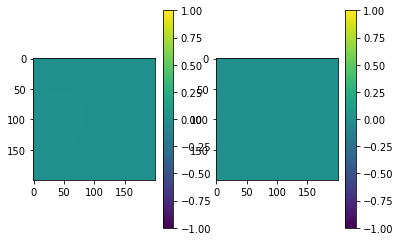

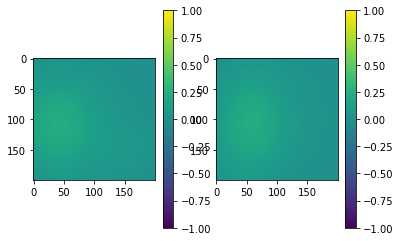

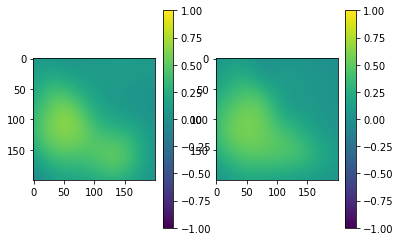

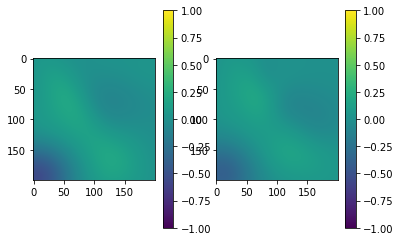

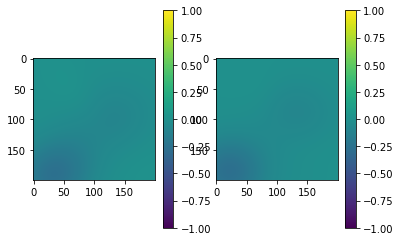

In [21]:
z_values = np.arange(0, 1, .2)
for z_v in z_values:
    plt.figure()
    plt.subplot(1,2,1)
    plot_2d_f(f_true, n_smps_per_dim=200, dims = [0, 1], fixed_values = z_v*np.ones(n_dims))
    plt.clim([-1, 1])
    plt.subplot(1,2,2)
    plot_2d_f(torch_mod_to_fcn(f_fit), n_smps_per_dim=200, dims = [0, 1], fixed_values = z_v*np.ones(n_dims))
    plt.clim([-1, 1])